In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle
import numpy as np
import functools
import sys
from tqdm import tqdm, trange
from aemulusnu_massfunction.utils import *
from aemulusnu_massfunction.emulator import *

from classy import Class

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

import pyccl as ccl


In [3]:

cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f)
a_list_f.close()

In [4]:
weird_boxes = []


errors = {a:{} for a in a_list}
X = []
Y = []
z_to_a = {}
a_to_z = {}
kt = np.logspace(-3, 1, 100) # h/Mpc
for box in tqdm(cosmo_params):
    if(box in weird_boxes):
        continue
    curr_cosmo = cosmo_params[box]
    if(box == 'Box_n50_0_1400'):
        print(curr_cosmo)

    curr_cosmo_values = [curr_cosmo[curr_key] for curr_key in key_ordering]

    h = curr_cosmo['H0']/100

    Ωb =  curr_cosmo['ombh2'] / h**2
    Ωc =  curr_cosmo['omch2'] / h**2

    cosmo = ccl.Cosmology(Omega_c=Ωc,
                          Omega_b=Ωb,
                          h=h,
                          A_s=curr_cosmo['10^9 As']*10**(-9),
                          n_s=curr_cosmo['ns'],
                          w0=curr_cosmo['w0'],
                          m_nu=[curr_cosmo['nu_mass_ev']/3, curr_cosmo['nu_mass_ev']/3, curr_cosmo['nu_mass_ev']/3])


    for a in a_list:
        z = scaleToRedshift(a)
#         if(z>2):
#             continue
        z_to_a[z] = a
        a_to_z[a] = z
        try:
            with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(box, a), "rb") as f:
                MLE_params = pickle.load(f)
                param_values = list(MLE_params.values())
                Y+= [param_values]
                X+= [curr_cosmo_values + [a]]
        except:
            print(box, z)

 32%|███▏      | 48/150 [00:14<00:30,  3.35it/s]

Box47_1400 2.3038301302700224


 67%|██████▋   | 100/150 [00:30<00:22,  2.23it/s]

{'ns': 0.97000003, 'H0': 67.0, 'w0': -1.0, 'ombh2': 0.0223, 'omch2': 0.12, 'nu_mass_ev': 0.07071068, '10^9 As': 2.10100315}


100%|██████████| 150/150 [00:59<00:00,  2.54it/s]


In [5]:
X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)
################################
print('scaling input')
in_scaler = Normalizer()
in_scaler.fit(X)
X = in_scaler.transform(X)
print(X.shape)


print('scaling output')
out_scaler = Standardizer()
out_scaler.fit(Y)
Y = out_scaler.transform(Y)
print(Y.shape)

##REMEMBER TO UNSCALE OUTPUT AND SAVE SCALERS#####

X_train = torch.from_numpy(X).float()
Y_train = torch.from_numpy(Y).float()
n_tasks = len(Y_train[0])

(2249, 8)
(2249, 4)
scaling input
(2249, 8)
scaling output
(2249, 4)


In [6]:
from aemulusnu_massfunction.emulator import *


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks,
                                                              has_global_noise=False, 
                                                              has_task_noise=True)
model = MultitaskGPModel(X_train, Y_train, likelihood)


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()


training_iterations = 500

In [7]:
epochs_iter = tqdm(range(training_iterations), desc="Iteration")


# Create the optimizer with the initial learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, amsgrad=True)  # Includes GaussianLikelihood parameters

for i in epochs_iter:
    # Training step
    model.train()
    likelihood.train()

    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()
    print('Iter %d/%d - Loss: %.4f' % (i + 1, training_iterations, loss.item()))

    # Change learning rate after half of iterations
#     if i == training_iterations//10:
#         lr = 0.1
#         print('reducing lr to 0.1')
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = lr

#     if i == 150:
#         lr = 0.01
#         print('reducing lr to 0.01')
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = lr
#-.926

Iteration:   0%|          | 1/500 [00:06<52:25,  6.30s/it, loss=2.31]

Iter 1/500 - Loss: 2.3109


Iteration:   0%|          | 2/500 [00:08<31:43,  3.82s/it, loss=2.03]

Iter 2/500 - Loss: 2.0348


Iteration:   1%|          | 3/500 [00:10<24:40,  2.98s/it, loss=1.78]

Iter 3/500 - Loss: 1.7796


Iteration:   1%|          | 4/500 [00:12<21:48,  2.64s/it, loss=1.55]

Iter 4/500 - Loss: 1.5457


Iteration:   1%|          | 5/500 [00:14<20:03,  2.43s/it, loss=1.33]

Iter 5/500 - Loss: 1.3334


Iteration:   1%|          | 6/500 [00:16<19:12,  2.33s/it, loss=1.14]

Iter 6/500 - Loss: 1.1433


Iteration:   1%|▏         | 7/500 [00:18<18:53,  2.30s/it, loss=0.976]

Iter 7/500 - Loss: 0.9764


Iteration:   2%|▏         | 8/500 [00:21<18:31,  2.26s/it, loss=0.834]

Iter 8/500 - Loss: 0.8344


Iteration:   2%|▏         | 9/500 [00:23<18:12,  2.23s/it, loss=0.72] 

Iter 9/500 - Loss: 0.7198


Iteration:   2%|▏         | 10/500 [00:27<23:00,  2.82s/it, loss=0.635]

Iter 10/500 - Loss: 0.6347


Iteration:   2%|▏         | 11/500 [00:29<21:08,  2.59s/it, loss=0.577]

Iter 11/500 - Loss: 0.5774


Iteration:   2%|▏         | 12/500 [00:31<19:55,  2.45s/it, loss=0.543]

Iter 12/500 - Loss: 0.5426


Iteration:   3%|▎         | 13/500 [00:33<18:55,  2.33s/it, loss=0.521]

Iter 13/500 - Loss: 0.5212


Iteration:   3%|▎         | 14/500 [00:35<18:17,  2.26s/it, loss=0.504]

Iter 14/500 - Loss: 0.5042


Iteration:   3%|▎         | 15/500 [00:37<17:36,  2.18s/it, loss=0.485]

Iter 15/500 - Loss: 0.4846


Iteration:   3%|▎         | 16/500 [00:39<17:21,  2.15s/it, loss=0.458]

Iter 16/500 - Loss: 0.4581


Iteration:   3%|▎         | 17/500 [00:41<17:13,  2.14s/it, loss=0.422]

Iter 17/500 - Loss: 0.4225


Iteration:   4%|▎         | 18/500 [00:44<17:32,  2.18s/it, loss=0.376]

Iter 18/500 - Loss: 0.3765


Iteration:   4%|▍         | 19/500 [00:46<17:38,  2.20s/it, loss=0.321]

Iter 19/500 - Loss: 0.3210


Iteration:   4%|▍         | 20/500 [00:48<17:24,  2.18s/it, loss=0.259]

Iter 20/500 - Loss: 0.2591


Iteration:   4%|▍         | 21/500 [00:50<16:56,  2.12s/it, loss=0.195]

Iter 21/500 - Loss: 0.1955


Iteration:   4%|▍         | 22/500 [00:52<17:09,  2.15s/it, loss=0.134]

Iter 22/500 - Loss: 0.1343


Iteration:   5%|▍         | 23/500 [00:55<17:14,  2.17s/it, loss=0.0783]

Iter 23/500 - Loss: 0.0783


Iteration:   5%|▍         | 24/500 [00:57<17:16,  2.18s/it, loss=0.0284]

Iter 24/500 - Loss: 0.0284


Iteration:   5%|▌         | 25/500 [00:59<16:48,  2.12s/it, loss=-.0148]

Iter 25/500 - Loss: -0.0148


Iteration:   5%|▌         | 26/500 [01:02<18:37,  2.36s/it, loss=-.0525]

Iter 26/500 - Loss: -0.0525


Iteration:   5%|▌         | 27/500 [01:04<17:39,  2.24s/it, loss=-.0868]

Iter 27/500 - Loss: -0.0868


Iteration:   6%|▌         | 28/500 [01:06<16:59,  2.16s/it, loss=-.12]  

Iter 28/500 - Loss: -0.1200


Iteration:   6%|▌         | 29/500 [01:08<16:35,  2.11s/it, loss=-.154]

Iter 29/500 - Loss: -0.1537


Iteration:   6%|▌         | 30/500 [01:10<16:11,  2.07s/it, loss=-.189]

Iter 30/500 - Loss: -0.1888


Iteration:   6%|▌         | 31/500 [01:12<17:19,  2.22s/it, loss=-.226]

Iter 31/500 - Loss: -0.2256


Iteration:   6%|▋         | 32/500 [01:14<16:57,  2.17s/it, loss=-.264]

Iter 32/500 - Loss: -0.2638


Iteration:   7%|▋         | 33/500 [01:16<16:30,  2.12s/it, loss=-.303]

Iter 33/500 - Loss: -0.3029


Iteration:   7%|▋         | 34/500 [01:18<16:10,  2.08s/it, loss=-.342]

Iter 34/500 - Loss: -0.3424


Iteration:   7%|▋         | 35/500 [01:20<16:12,  2.09s/it, loss=-.381]

Iter 35/500 - Loss: -0.3813


Iteration:   7%|▋         | 36/500 [01:22<16:00,  2.07s/it, loss=-.419]

Iter 36/500 - Loss: -0.4189


Iteration:   7%|▋         | 37/500 [01:24<15:47,  2.05s/it, loss=-.454]

Iter 37/500 - Loss: -0.4543


Iteration:   8%|▊         | 38/500 [01:26<15:38,  2.03s/it, loss=-.487]

Iter 38/500 - Loss: -0.4869


Iteration:   8%|▊         | 39/500 [01:28<15:30,  2.02s/it, loss=-.517]

Iter 39/500 - Loss: -0.5166


Iteration:   8%|▊         | 40/500 [01:30<15:27,  2.02s/it, loss=-.544]

Iter 40/500 - Loss: -0.5436


Iteration:   8%|▊         | 41/500 [01:32<15:22,  2.01s/it, loss=-.569]

Iter 41/500 - Loss: -0.5691


Iteration:   8%|▊         | 42/500 [01:34<15:24,  2.02s/it, loss=-.594]

Iter 42/500 - Loss: -0.5943


Iteration:   9%|▊         | 43/500 [01:36<15:21,  2.02s/it, loss=-.621]

Iter 43/500 - Loss: -0.6205


Iteration:   9%|▉         | 44/500 [01:38<15:20,  2.02s/it, loss=-.648]

Iter 44/500 - Loss: -0.6480


Iteration:   9%|▉         | 45/500 [01:40<15:19,  2.02s/it, loss=-.676]

Iter 45/500 - Loss: -0.6759


Iteration:   9%|▉         | 46/500 [01:42<15:32,  2.05s/it, loss=-.703]

Iter 46/500 - Loss: -0.7033


Iteration:   9%|▉         | 47/500 [01:45<16:24,  2.17s/it, loss=-.729]

Iter 47/500 - Loss: -0.7291


Iteration:  10%|▉         | 48/500 [01:47<15:56,  2.12s/it, loss=-.753]

Iter 48/500 - Loss: -0.7531


Iteration:  10%|▉         | 49/500 [01:49<15:39,  2.08s/it, loss=-.775]

Iter 49/500 - Loss: -0.7753


Iteration:  10%|█         | 50/500 [01:51<15:31,  2.07s/it, loss=-.796]

Iter 50/500 - Loss: -0.7962


Iteration:  10%|█         | 51/500 [01:53<15:24,  2.06s/it, loss=-.816]

Iter 51/500 - Loss: -0.8162


Iteration:  10%|█         | 52/500 [01:55<15:16,  2.05s/it, loss=-.836]

Iter 52/500 - Loss: -0.8357


Iteration:  11%|█         | 53/500 [01:57<15:07,  2.03s/it, loss=-.855]

Iter 53/500 - Loss: -0.8550


Iteration:  11%|█         | 54/500 [01:59<14:59,  2.02s/it, loss=-.874]

Iter 54/500 - Loss: -0.8737


Iteration:  11%|█         | 55/500 [02:02<16:17,  2.20s/it, loss=-.891]

Iter 55/500 - Loss: -0.8914


Iteration:  11%|█         | 56/500 [02:04<15:51,  2.14s/it, loss=-.907]

Iter 56/500 - Loss: -0.9075


Iteration:  11%|█▏        | 57/500 [02:06<16:58,  2.30s/it, loss=-.922]

Iter 57/500 - Loss: -0.9216


Iteration:  12%|█▏        | 58/500 [02:08<16:20,  2.22s/it, loss=-.934]

Iter 58/500 - Loss: -0.9343


Iteration:  12%|█▏        | 59/500 [02:10<15:50,  2.16s/it, loss=-.947]

Iter 59/500 - Loss: -0.9468


Iteration:  12%|█▏        | 60/500 [02:12<15:26,  2.11s/it, loss=-.96] 

Iter 60/500 - Loss: -0.9598


Iteration:  12%|█▏        | 61/500 [02:14<15:12,  2.08s/it, loss=-.973]

Iter 61/500 - Loss: -0.9728


Iteration:  12%|█▏        | 62/500 [02:16<15:02,  2.06s/it, loss=-.985]

Iter 62/500 - Loss: -0.9851


Iteration:  13%|█▎        | 63/500 [02:18<14:51,  2.04s/it, loss=-.996]

Iter 63/500 - Loss: -0.9962


Iteration:  13%|█▎        | 64/500 [02:20<14:43,  2.03s/it, loss=-1.01]

Iter 64/500 - Loss: -1.0063


Iteration:  13%|█▎        | 65/500 [02:22<14:43,  2.03s/it, loss=-1.02]

Iter 65/500 - Loss: -1.0159


Iteration:  13%|█▎        | 66/500 [02:24<14:37,  2.02s/it, loss=-1.03]

Iter 66/500 - Loss: -1.0252


Iteration:  13%|█▎        | 67/500 [02:26<14:32,  2.01s/it, loss=-1.03]

Iter 67/500 - Loss: -1.0343


Iteration:  14%|█▎        | 68/500 [02:28<14:28,  2.01s/it, loss=-1.04]

Iter 68/500 - Loss: -1.0431


Iteration:  14%|█▍        | 69/500 [02:30<14:26,  2.01s/it, loss=-1.05]

Iter 69/500 - Loss: -1.0510


Iteration:  14%|█▍        | 70/500 [02:32<14:26,  2.01s/it, loss=-1.06]

Iter 70/500 - Loss: -1.0582


Iteration:  14%|█▍        | 71/500 [02:34<14:23,  2.01s/it, loss=-1.06]

Iter 71/500 - Loss: -1.0645


Iteration:  14%|█▍        | 72/500 [02:36<14:19,  2.01s/it, loss=-1.07]

Iter 72/500 - Loss: -1.0704


Iteration:  15%|█▍        | 73/500 [02:38<14:20,  2.02s/it, loss=-1.08]

Iter 73/500 - Loss: -1.0759


Iteration:  15%|█▍        | 74/500 [02:40<14:18,  2.02s/it, loss=-1.08]

Iter 74/500 - Loss: -1.0803


Iteration:  15%|█▌        | 75/500 [02:42<14:14,  2.01s/it, loss=-1.08]

Iter 75/500 - Loss: -1.0819


Iteration:  15%|█▌        | 76/500 [02:44<14:13,  2.01s/it, loss=-1.09]

Iter 76/500 - Loss: -1.0891


Iteration:  15%|█▌        | 77/500 [02:46<14:10,  2.01s/it, loss=-1.09]

Iter 77/500 - Loss: -1.0901


Iteration:  16%|█▌        | 78/500 [02:49<14:07,  2.01s/it, loss=-1.09]

Iter 78/500 - Loss: -1.0943


Iteration:  16%|█▌        | 79/500 [02:51<14:05,  2.01s/it, loss=-1.1] 

Iter 79/500 - Loss: -1.0953


Iteration:  16%|█▌        | 80/500 [02:53<14:06,  2.02s/it, loss=-1.1]

Iter 80/500 - Loss: -1.0994


Iteration:  16%|█▌        | 81/500 [02:55<14:03,  2.01s/it, loss=-1.1]

Iter 81/500 - Loss: -1.0995


Iteration:  16%|█▋        | 82/500 [02:57<14:00,  2.01s/it, loss=-1.1]

Iter 82/500 - Loss: -1.1034


Iteration:  17%|█▋        | 83/500 [02:59<13:59,  2.01s/it, loss=-1.1]

Iter 83/500 - Loss: -1.1033


Iteration:  17%|█▋        | 84/500 [03:01<15:00,  2.17s/it, loss=-1.11]

Iter 84/500 - Loss: -1.1065


Iteration:  17%|█▋        | 85/500 [03:03<14:39,  2.12s/it, loss=-1.11]

Iter 85/500 - Loss: -1.1064


Iteration:  17%|█▋        | 86/500 [03:05<14:30,  2.10s/it, loss=-1.11]

Iter 86/500 - Loss: -1.1090


Iteration:  17%|█▋        | 87/500 [03:07<14:17,  2.08s/it, loss=-1.11]

Iter 87/500 - Loss: -1.1092


Iteration:  18%|█▊        | 88/500 [03:09<14:08,  2.06s/it, loss=-1.11]

Iter 88/500 - Loss: -1.1113


Iteration:  18%|█▊        | 89/500 [03:11<14:02,  2.05s/it, loss=-1.11]

Iter 89/500 - Loss: -1.1117


Iteration:  18%|█▊        | 90/500 [03:13<13:57,  2.04s/it, loss=-1.11]

Iter 90/500 - Loss: -1.1133


Iteration:  18%|█▊        | 91/500 [03:15<13:52,  2.04s/it, loss=-1.11]

Iter 91/500 - Loss: -1.1135


Iteration:  18%|█▊        | 92/500 [03:17<13:51,  2.04s/it, loss=-1.11]

Iter 92/500 - Loss: -1.1148


Iteration:  19%|█▊        | 93/500 [03:19<13:46,  2.03s/it, loss=-1.11]

Iter 93/500 - Loss: -1.1150


Iteration:  19%|█▉        | 94/500 [03:21<14:00,  2.07s/it, loss=-1.12]

Iter 94/500 - Loss: -1.1160


Iteration:  19%|█▉        | 95/500 [03:24<13:50,  2.05s/it, loss=-1.12]

Iter 95/500 - Loss: -1.1162


Iteration:  19%|█▉        | 96/500 [03:26<13:44,  2.04s/it, loss=-1.12]

Iter 96/500 - Loss: -1.1168


Iteration:  19%|█▉        | 97/500 [03:28<13:46,  2.05s/it, loss=-1.12]

Iter 97/500 - Loss: -1.1171


Iteration:  20%|█▉        | 98/500 [03:30<13:42,  2.05s/it, loss=-1.12]

Iter 98/500 - Loss: -1.1173


Iteration:  20%|█▉        | 99/500 [03:32<13:41,  2.05s/it, loss=-1.12]

Iter 99/500 - Loss: -1.1177


Iteration:  20%|██        | 100/500 [03:34<13:35,  2.04s/it, loss=-1.12]

Iter 100/500 - Loss: -1.1178


Iteration:  20%|██        | 101/500 [03:36<13:31,  2.03s/it, loss=-1.12]

Iter 101/500 - Loss: -1.1182


Iteration:  20%|██        | 102/500 [03:38<13:36,  2.05s/it, loss=-1.12]

Iter 102/500 - Loss: -1.1183


Iteration:  21%|██        | 103/500 [03:40<13:55,  2.11s/it, loss=-1.12]

Iter 103/500 - Loss: -1.1186


Iteration:  21%|██        | 104/500 [03:42<14:14,  2.16s/it, loss=-1.12]

Iter 104/500 - Loss: -1.1187


Iteration:  21%|██        | 105/500 [03:44<14:03,  2.14s/it, loss=-1.12]

Iter 105/500 - Loss: -1.1190


Iteration:  21%|██        | 106/500 [03:47<14:08,  2.15s/it, loss=-1.12]

Iter 106/500 - Loss: -1.1192


Iteration:  21%|██▏       | 107/500 [03:49<14:08,  2.16s/it, loss=-1.12]

Iter 107/500 - Loss: -1.1195


Iteration:  22%|██▏       | 108/500 [03:51<14:48,  2.27s/it, loss=-1.12]

Iter 108/500 - Loss: -1.1197


Iteration:  22%|██▏       | 109/500 [03:53<14:21,  2.20s/it, loss=-1.12]

Iter 109/500 - Loss: -1.1203


Iteration:  22%|██▏       | 110/500 [03:55<14:05,  2.17s/it, loss=-1.12]

Iter 110/500 - Loss: -1.1208


Iteration:  22%|██▏       | 111/500 [03:58<13:58,  2.16s/it, loss=-1.12]

Iter 111/500 - Loss: -1.1219


Iteration:  22%|██▏       | 112/500 [04:00<14:03,  2.17s/it, loss=-1.12]

Iter 112/500 - Loss: -1.1234


Iteration:  23%|██▎       | 113/500 [04:02<13:59,  2.17s/it, loss=-1.13]

Iter 113/500 - Loss: -1.1259


Iteration:  23%|██▎       | 114/500 [04:04<13:50,  2.15s/it, loss=-1.13]

Iter 114/500 - Loss: -1.1295


Iteration:  23%|██▎       | 115/500 [04:06<13:38,  2.13s/it, loss=-1.13]

Iter 115/500 - Loss: -1.1344


Iteration:  23%|██▎       | 116/500 [04:08<13:31,  2.11s/it, loss=-1.14]

Iter 116/500 - Loss: -1.1399


Iteration:  23%|██▎       | 117/500 [04:10<13:30,  2.12s/it, loss=-1.15]

Iter 117/500 - Loss: -1.1456


Iteration:  24%|██▎       | 118/500 [04:12<13:23,  2.10s/it, loss=-1.15]

Iter 118/500 - Loss: -1.1511


Iteration:  24%|██▍       | 119/500 [04:14<13:18,  2.10s/it, loss=-1.16]

Iter 119/500 - Loss: -1.1568


Iteration:  24%|██▍       | 120/500 [04:17<13:17,  2.10s/it, loss=-1.16]

Iter 120/500 - Loss: -1.1623


Iteration:  24%|██▍       | 121/500 [04:19<13:15,  2.10s/it, loss=-1.17]

Iter 121/500 - Loss: -1.1679


Iteration:  24%|██▍       | 122/500 [04:21<13:12,  2.10s/it, loss=-1.17]

Iter 122/500 - Loss: -1.1733


Iteration:  25%|██▍       | 123/500 [04:23<13:08,  2.09s/it, loss=-1.18]

Iter 123/500 - Loss: -1.1789


Iteration:  25%|██▍       | 124/500 [04:25<13:06,  2.09s/it, loss=-1.18]

Iter 124/500 - Loss: -1.1844


Iteration:  25%|██▌       | 125/500 [04:27<13:04,  2.09s/it, loss=-1.19]

Iter 125/500 - Loss: -1.1896


Iteration:  25%|██▌       | 126/500 [04:29<13:00,  2.09s/it, loss=-1.19]

Iter 126/500 - Loss: -1.1942


Iteration:  25%|██▌       | 127/500 [04:31<12:59,  2.09s/it, loss=-1.2] 

Iter 127/500 - Loss: -1.1980


Iteration:  26%|██▌       | 128/500 [04:33<12:57,  2.09s/it, loss=-1.2]

Iter 128/500 - Loss: -1.2013


Iteration:  26%|██▌       | 129/500 [04:35<12:54,  2.09s/it, loss=-1.2]

Iter 129/500 - Loss: -1.2042


Iteration:  26%|██▌       | 130/500 [04:37<12:53,  2.09s/it, loss=-1.21]

Iter 130/500 - Loss: -1.2067


Iteration:  26%|██▌       | 131/500 [04:40<12:50,  2.09s/it, loss=-1.21]

Iter 131/500 - Loss: -1.2088


Iteration:  26%|██▋       | 132/500 [04:42<12:49,  2.09s/it, loss=-1.21]

Iter 132/500 - Loss: -1.2108


Iteration:  27%|██▋       | 133/500 [04:44<12:47,  2.09s/it, loss=-1.21]

Iter 133/500 - Loss: -1.2125


Iteration:  27%|██▋       | 134/500 [04:46<12:44,  2.09s/it, loss=-1.21]

Iter 134/500 - Loss: -1.2141


Iteration:  27%|██▋       | 135/500 [04:48<12:42,  2.09s/it, loss=-1.22]

Iter 135/500 - Loss: -1.2155


Iteration:  27%|██▋       | 136/500 [04:50<12:41,  2.09s/it, loss=-1.22]

Iter 136/500 - Loss: -1.2166


Iteration:  27%|██▋       | 137/500 [04:52<12:39,  2.09s/it, loss=-1.22]

Iter 137/500 - Loss: -1.2176


Iteration:  28%|██▊       | 138/500 [04:54<12:37,  2.09s/it, loss=-1.22]

Iter 138/500 - Loss: -1.2185


Iteration:  28%|██▊       | 139/500 [04:56<12:35,  2.09s/it, loss=-1.22]

Iter 139/500 - Loss: -1.2194


Iteration:  28%|██▊       | 140/500 [04:58<12:33,  2.09s/it, loss=-1.22]

Iter 140/500 - Loss: -1.2202


Iteration:  28%|██▊       | 141/500 [05:01<13:32,  2.26s/it, loss=-1.22]

Iter 141/500 - Loss: -1.2210


Iteration:  28%|██▊       | 142/500 [05:03<13:11,  2.21s/it, loss=-1.22]

Iter 142/500 - Loss: -1.2218


Iteration:  29%|██▊       | 143/500 [05:05<12:54,  2.17s/it, loss=-1.22]

Iter 143/500 - Loss: -1.2226


Iteration:  29%|██▉       | 144/500 [05:07<12:42,  2.14s/it, loss=-1.22]

Iter 144/500 - Loss: -1.2234


Iteration:  29%|██▉       | 145/500 [05:09<12:38,  2.14s/it, loss=-1.22]

Iter 145/500 - Loss: -1.2241


Iteration:  29%|██▉       | 146/500 [05:11<12:29,  2.12s/it, loss=-1.22]

Iter 146/500 - Loss: -1.2248


Iteration:  29%|██▉       | 147/500 [05:14<12:23,  2.11s/it, loss=-1.23]

Iter 147/500 - Loss: -1.2255


Iteration:  30%|██▉       | 148/500 [05:16<12:20,  2.10s/it, loss=-1.23]

Iter 148/500 - Loss: -1.2263


Iteration:  30%|██▉       | 149/500 [05:18<12:16,  2.10s/it, loss=-1.23]

Iter 149/500 - Loss: -1.2270


Iteration:  30%|███       | 150/500 [05:20<12:12,  2.09s/it, loss=-1.23]

Iter 150/500 - Loss: -1.2277


Iteration:  30%|███       | 151/500 [05:22<12:11,  2.10s/it, loss=-1.23]

Iter 151/500 - Loss: -1.2285


Iteration:  30%|███       | 152/500 [05:24<12:08,  2.09s/it, loss=-1.23]

Iter 152/500 - Loss: -1.2292


Iteration:  31%|███       | 153/500 [05:26<12:05,  2.09s/it, loss=-1.23]

Iter 153/500 - Loss: -1.2299


Iteration:  31%|███       | 154/500 [05:28<12:05,  2.10s/it, loss=-1.23]

Iter 154/500 - Loss: -1.2306


Iteration:  31%|███       | 155/500 [05:30<12:02,  2.10s/it, loss=-1.23]

Iter 155/500 - Loss: -1.2313


Iteration:  31%|███       | 156/500 [05:32<12:00,  2.09s/it, loss=-1.23]

Iter 156/500 - Loss: -1.2320


Iteration:  31%|███▏      | 157/500 [05:35<12:00,  2.10s/it, loss=-1.23]

Iter 157/500 - Loss: -1.2326


Iteration:  32%|███▏      | 158/500 [05:37<11:56,  2.09s/it, loss=-1.23]

Iter 158/500 - Loss: -1.2332


Iteration:  32%|███▏      | 159/500 [05:39<11:53,  2.09s/it, loss=-1.23]

Iter 159/500 - Loss: -1.2339


Iteration:  32%|███▏      | 160/500 [05:41<11:50,  2.09s/it, loss=-1.23]

Iter 160/500 - Loss: -1.2345


Iteration:  32%|███▏      | 161/500 [05:43<12:02,  2.13s/it, loss=-1.24]

Iter 161/500 - Loss: -1.2350


Iteration:  32%|███▏      | 162/500 [05:45<12:01,  2.13s/it, loss=-1.24]

Iter 162/500 - Loss: -1.2356


Iteration:  33%|███▎      | 163/500 [05:47<11:55,  2.12s/it, loss=-1.24]

Iter 163/500 - Loss: -1.2361


Iteration:  33%|███▎      | 164/500 [05:49<11:50,  2.11s/it, loss=-1.24]

Iter 164/500 - Loss: -1.2367


Iteration:  33%|███▎      | 165/500 [05:51<11:46,  2.11s/it, loss=-1.24]

Iter 165/500 - Loss: -1.2372


Iteration:  33%|███▎      | 166/500 [05:54<11:41,  2.10s/it, loss=-1.24]

Iter 166/500 - Loss: -1.2377


Iteration:  33%|███▎      | 167/500 [05:56<11:37,  2.10s/it, loss=-1.24]

Iter 167/500 - Loss: -1.2382


Iteration:  34%|███▎      | 168/500 [05:58<11:38,  2.10s/it, loss=-1.24]

Iter 168/500 - Loss: -1.2387


Iteration:  34%|███▍      | 169/500 [06:00<11:55,  2.16s/it, loss=-1.24]

Iter 169/500 - Loss: -1.2392


Iteration:  34%|███▍      | 170/500 [06:02<11:45,  2.14s/it, loss=-1.24]

Iter 170/500 - Loss: -1.2397


Iteration:  34%|███▍      | 171/500 [06:04<11:42,  2.14s/it, loss=-1.24]

Iter 171/500 - Loss: -1.2402


Iteration:  34%|███▍      | 172/500 [06:06<11:35,  2.12s/it, loss=-1.24]

Iter 172/500 - Loss: -1.2407


Iteration:  35%|███▍      | 173/500 [06:08<11:30,  2.11s/it, loss=-1.24]

Iter 173/500 - Loss: -1.2413


Iteration:  35%|███▍      | 174/500 [06:10<11:26,  2.11s/it, loss=-1.24]

Iter 174/500 - Loss: -1.2419


Iteration:  35%|███▌      | 175/500 [06:13<11:23,  2.10s/it, loss=-1.24]

Iter 175/500 - Loss: -1.2425


Iteration:  35%|███▌      | 176/500 [06:15<11:19,  2.10s/it, loss=-1.24]

Iter 176/500 - Loss: -1.2432


Iteration:  35%|███▌      | 177/500 [06:17<11:17,  2.10s/it, loss=-1.24]

Iter 177/500 - Loss: -1.2439


Iteration:  36%|███▌      | 178/500 [06:19<11:15,  2.10s/it, loss=-1.24]

Iter 178/500 - Loss: -1.2447


Iteration:  36%|███▌      | 179/500 [06:21<11:19,  2.12s/it, loss=-1.25]

Iter 179/500 - Loss: -1.2454


Iteration:  36%|███▌      | 180/500 [06:23<11:15,  2.11s/it, loss=-1.25]

Iter 180/500 - Loss: -1.2461


Iteration:  36%|███▌      | 181/500 [06:25<11:13,  2.11s/it, loss=-1.25]

Iter 181/500 - Loss: -1.2468


Iteration:  36%|███▋      | 182/500 [06:27<11:13,  2.12s/it, loss=-1.25]

Iter 182/500 - Loss: -1.2474


Iteration:  37%|███▋      | 183/500 [06:29<11:10,  2.11s/it, loss=-1.25]

Iter 183/500 - Loss: -1.2480


Iteration:  37%|███▋      | 184/500 [06:32<11:06,  2.11s/it, loss=-1.25]

Iter 184/500 - Loss: -1.2486


Iteration:  37%|███▋      | 185/500 [06:34<11:07,  2.12s/it, loss=-1.25]

Iter 185/500 - Loss: -1.2492


Iteration:  37%|███▋      | 186/500 [06:36<11:03,  2.11s/it, loss=-1.25]

Iter 186/500 - Loss: -1.2497


Iteration:  37%|███▋      | 187/500 [06:38<11:02,  2.12s/it, loss=-1.25]

Iter 187/500 - Loss: -1.2502


Iteration:  38%|███▊      | 188/500 [06:40<11:07,  2.14s/it, loss=-1.25]

Iter 188/500 - Loss: -1.2507


Iteration:  38%|███▊      | 189/500 [06:42<11:01,  2.13s/it, loss=-1.25]

Iter 189/500 - Loss: -1.2512


Iteration:  38%|███▊      | 190/500 [06:44<10:56,  2.12s/it, loss=-1.25]

Iter 190/500 - Loss: -1.2517


Iteration:  38%|███▊      | 191/500 [06:46<10:54,  2.12s/it, loss=-1.25]

Iter 191/500 - Loss: -1.2522


Iteration:  38%|███▊      | 192/500 [06:49<10:50,  2.11s/it, loss=-1.25]

Iter 192/500 - Loss: -1.2527


Iteration:  39%|███▊      | 193/500 [06:51<10:45,  2.10s/it, loss=-1.25]

Iter 193/500 - Loss: -1.2532


Iteration:  39%|███▉      | 194/500 [06:53<10:42,  2.10s/it, loss=-1.25]

Iter 194/500 - Loss: -1.2537


Iteration:  39%|███▉      | 195/500 [06:56<13:00,  2.56s/it, loss=-1.25]

Iter 195/500 - Loss: -1.2542


Iteration:  39%|███▉      | 196/500 [06:58<12:15,  2.42s/it, loss=-1.25]

Iter 196/500 - Loss: -1.2547


Iteration:  39%|███▉      | 197/500 [07:02<13:19,  2.64s/it, loss=-1.26]

Iter 197/500 - Loss: -1.2552


Iteration:  40%|███▉      | 198/500 [07:04<12:29,  2.48s/it, loss=-1.26]

Iter 198/500 - Loss: -1.2557


Iteration:  40%|███▉      | 199/500 [07:06<11:56,  2.38s/it, loss=-1.26]

Iter 199/500 - Loss: -1.2563


Iteration:  40%|████      | 200/500 [07:08<11:34,  2.31s/it, loss=-1.26]

Iter 200/500 - Loss: -1.2568


Iteration:  40%|████      | 201/500 [07:10<11:17,  2.27s/it, loss=-1.26]

Iter 201/500 - Loss: -1.2574


Iteration:  40%|████      | 202/500 [07:12<11:00,  2.22s/it, loss=-1.26]

Iter 202/500 - Loss: -1.2580


Iteration:  41%|████      | 203/500 [07:14<10:48,  2.18s/it, loss=-1.26]

Iter 203/500 - Loss: -1.2585


Iteration:  41%|████      | 204/500 [07:16<10:38,  2.16s/it, loss=-1.26]

Iter 204/500 - Loss: -1.2591


Iteration:  41%|████      | 205/500 [07:19<10:29,  2.14s/it, loss=-1.26]

Iter 205/500 - Loss: -1.2596


Iteration:  41%|████      | 206/500 [07:21<10:24,  2.12s/it, loss=-1.26]

Iter 206/500 - Loss: -1.2601


Iteration:  41%|████▏     | 207/500 [07:23<10:40,  2.19s/it, loss=-1.26]

Iter 207/500 - Loss: -1.2606


Iteration:  42%|████▏     | 208/500 [07:25<10:32,  2.17s/it, loss=-1.26]

Iter 208/500 - Loss: -1.2611


Iteration:  42%|████▏     | 209/500 [07:27<10:26,  2.15s/it, loss=-1.26]

Iter 209/500 - Loss: -1.2616


Iteration:  42%|████▏     | 210/500 [07:29<10:20,  2.14s/it, loss=-1.26]

Iter 210/500 - Loss: -1.2621


Iteration:  42%|████▏     | 211/500 [07:31<10:15,  2.13s/it, loss=-1.26]

Iter 211/500 - Loss: -1.2625


Iteration:  42%|████▏     | 212/500 [07:34<10:12,  2.13s/it, loss=-1.26]

Iter 212/500 - Loss: -1.2630


Iteration:  43%|████▎     | 213/500 [07:36<10:07,  2.12s/it, loss=-1.26]

Iter 213/500 - Loss: -1.2634


Iteration:  43%|████▎     | 214/500 [07:38<10:02,  2.11s/it, loss=-1.26]

Iter 214/500 - Loss: -1.2639


Iteration:  43%|████▎     | 215/500 [07:40<09:58,  2.10s/it, loss=-1.26]

Iter 215/500 - Loss: -1.2643


Iteration:  43%|████▎     | 216/500 [07:42<09:57,  2.10s/it, loss=-1.26]

Iter 216/500 - Loss: -1.2647


Iteration:  43%|████▎     | 217/500 [07:44<09:54,  2.10s/it, loss=-1.27]

Iter 217/500 - Loss: -1.2650


Iteration:  44%|████▎     | 218/500 [07:46<09:53,  2.10s/it, loss=-1.27]

Iter 218/500 - Loss: -1.2654


Iteration:  44%|████▍     | 219/500 [07:48<09:50,  2.10s/it, loss=-1.27]

Iter 219/500 - Loss: -1.2658


Iteration:  44%|████▍     | 220/500 [07:50<09:47,  2.10s/it, loss=-1.27]

Iter 220/500 - Loss: -1.2661


Iteration:  44%|████▍     | 221/500 [07:52<09:45,  2.10s/it, loss=-1.27]

Iter 221/500 - Loss: -1.2665


Iteration:  44%|████▍     | 222/500 [07:55<09:43,  2.10s/it, loss=-1.27]

Iter 222/500 - Loss: -1.2668


Iteration:  45%|████▍     | 223/500 [07:57<09:41,  2.10s/it, loss=-1.27]

Iter 223/500 - Loss: -1.2672


Iteration:  45%|████▍     | 224/500 [07:59<09:39,  2.10s/it, loss=-1.27]

Iter 224/500 - Loss: -1.2675


Iteration:  45%|████▌     | 225/500 [08:02<11:16,  2.46s/it, loss=-1.27]

Iter 225/500 - Loss: -1.2678


Iteration:  45%|████▌     | 226/500 [08:04<10:46,  2.36s/it, loss=-1.27]

Iter 226/500 - Loss: -1.2681


Iteration:  45%|████▌     | 227/500 [08:06<10:22,  2.28s/it, loss=-1.27]

Iter 227/500 - Loss: -1.2684


Iteration:  46%|████▌     | 228/500 [08:08<10:05,  2.23s/it, loss=-1.27]

Iter 228/500 - Loss: -1.2687


Iteration:  46%|████▌     | 229/500 [08:10<09:52,  2.19s/it, loss=-1.27]

Iter 229/500 - Loss: -1.2690


Iteration:  46%|████▌     | 230/500 [08:13<09:42,  2.16s/it, loss=-1.27]

Iter 230/500 - Loss: -1.2693


Iteration:  46%|████▌     | 231/500 [08:15<09:38,  2.15s/it, loss=-1.27]

Iter 231/500 - Loss: -1.2696


Iteration:  46%|████▋     | 232/500 [08:17<09:32,  2.14s/it, loss=-1.27]

Iter 232/500 - Loss: -1.2699


Iteration:  47%|████▋     | 233/500 [08:19<09:28,  2.13s/it, loss=-1.27]

Iter 233/500 - Loss: -1.2702


Iteration:  47%|████▋     | 234/500 [08:21<09:25,  2.13s/it, loss=-1.27]

Iter 234/500 - Loss: -1.2705


Iteration:  47%|████▋     | 235/500 [08:23<09:21,  2.12s/it, loss=-1.27]

Iter 235/500 - Loss: -1.2708


Iteration:  47%|████▋     | 236/500 [08:25<09:18,  2.11s/it, loss=-1.27]

Iter 236/500 - Loss: -1.2712


Iteration:  47%|████▋     | 237/500 [08:27<09:16,  2.12s/it, loss=-1.27]

Iter 237/500 - Loss: -1.2715


Iteration:  48%|████▊     | 238/500 [08:29<09:12,  2.11s/it, loss=-1.27]

Iter 238/500 - Loss: -1.2720


Iteration:  48%|████▊     | 239/500 [08:32<09:09,  2.10s/it, loss=-1.27]

Iter 239/500 - Loss: -1.2726


Iteration:  48%|████▊     | 240/500 [08:34<09:08,  2.11s/it, loss=-1.27]

Iter 240/500 - Loss: -1.2732


Iteration:  48%|████▊     | 241/500 [08:36<09:05,  2.10s/it, loss=-1.27]

Iter 241/500 - Loss: -1.2740


Iteration:  48%|████▊     | 242/500 [08:38<09:04,  2.11s/it, loss=-1.28]

Iter 242/500 - Loss: -1.2750


Iteration:  49%|████▊     | 243/500 [08:40<09:01,  2.11s/it, loss=-1.28]

Iter 243/500 - Loss: -1.2761


Iteration:  49%|████▉     | 244/500 [08:42<08:59,  2.11s/it, loss=-1.28]

Iter 244/500 - Loss: -1.2773


Iteration:  49%|████▉     | 245/500 [08:44<09:01,  2.12s/it, loss=-1.28]

Iter 245/500 - Loss: -1.2785


Iteration:  49%|████▉     | 246/500 [08:46<08:57,  2.12s/it, loss=-1.28]

Iter 246/500 - Loss: -1.2796


Iteration:  49%|████▉     | 247/500 [08:48<08:54,  2.11s/it, loss=-1.28]

Iter 247/500 - Loss: -1.2805


Iteration:  50%|████▉     | 248/500 [08:51<08:51,  2.11s/it, loss=-1.28]

Iter 248/500 - Loss: -1.2814


Iteration:  50%|████▉     | 249/500 [08:53<08:48,  2.11s/it, loss=-1.28]

Iter 249/500 - Loss: -1.2821


Iteration:  50%|█████     | 250/500 [08:55<08:47,  2.11s/it, loss=-1.28]

Iter 250/500 - Loss: -1.2827


Iteration:  50%|█████     | 251/500 [08:57<08:47,  2.12s/it, loss=-1.28]

Iter 251/500 - Loss: -1.2833


Iteration:  50%|█████     | 252/500 [08:59<08:43,  2.11s/it, loss=-1.28]

Iter 252/500 - Loss: -1.2838


Iteration:  51%|█████     | 253/500 [09:02<09:52,  2.40s/it, loss=-1.28]

Iter 253/500 - Loss: -1.2843


Iteration:  51%|█████     | 254/500 [09:04<09:29,  2.32s/it, loss=-1.28]

Iter 254/500 - Loss: -1.2848


Iteration:  51%|█████     | 255/500 [09:06<09:10,  2.25s/it, loss=-1.29]

Iter 255/500 - Loss: -1.2852


Iteration:  51%|█████     | 256/500 [09:08<08:57,  2.20s/it, loss=-1.29]

Iter 256/500 - Loss: -1.2856


Iteration:  51%|█████▏    | 257/500 [09:10<08:48,  2.17s/it, loss=-1.29]

Iter 257/500 - Loss: -1.2860


Iteration:  52%|█████▏    | 258/500 [09:13<08:40,  2.15s/it, loss=-1.29]

Iter 258/500 - Loss: -1.2864


Iteration:  52%|█████▏    | 259/500 [09:15<08:36,  2.14s/it, loss=-1.29]

Iter 259/500 - Loss: -1.2868


Iteration:  52%|█████▏    | 260/500 [09:17<08:32,  2.13s/it, loss=-1.29]

Iter 260/500 - Loss: -1.2872


Iteration:  52%|█████▏    | 261/500 [09:19<08:29,  2.13s/it, loss=-1.29]

Iter 261/500 - Loss: -1.2875


Iteration:  52%|█████▏    | 262/500 [09:21<08:26,  2.13s/it, loss=-1.29]

Iter 262/500 - Loss: -1.2879


Iteration:  53%|█████▎    | 263/500 [09:23<08:39,  2.19s/it, loss=-1.29]

Iter 263/500 - Loss: -1.2882


Iteration:  53%|█████▎    | 264/500 [09:25<08:31,  2.17s/it, loss=-1.29]

Iter 264/500 - Loss: -1.2885


Iteration:  53%|█████▎    | 265/500 [09:28<08:24,  2.15s/it, loss=-1.29]

Iter 265/500 - Loss: -1.2888


Iteration:  53%|█████▎    | 266/500 [09:30<08:20,  2.14s/it, loss=-1.29]

Iter 266/500 - Loss: -1.2891


Iteration:  53%|█████▎    | 267/500 [09:32<08:16,  2.13s/it, loss=-1.29]

Iter 267/500 - Loss: -1.2894


Iteration:  54%|█████▎    | 268/500 [09:34<08:13,  2.13s/it, loss=-1.29]

Iter 268/500 - Loss: -1.2897


Iteration:  54%|█████▍    | 269/500 [09:36<08:14,  2.14s/it, loss=-1.29]

Iter 269/500 - Loss: -1.2899


Iteration:  54%|█████▍    | 270/500 [09:38<08:10,  2.13s/it, loss=-1.29]

Iter 270/500 - Loss: -1.2902


Iteration:  54%|█████▍    | 271/500 [09:40<08:06,  2.12s/it, loss=-1.29]

Iter 271/500 - Loss: -1.2904


Iteration:  54%|█████▍    | 272/500 [09:42<08:03,  2.12s/it, loss=-1.29]

Iter 272/500 - Loss: -1.2907


Iteration:  55%|█████▍    | 273/500 [09:45<07:59,  2.11s/it, loss=-1.29]

Iter 273/500 - Loss: -1.2909


Iteration:  55%|█████▍    | 274/500 [09:47<07:57,  2.11s/it, loss=-1.29]

Iter 274/500 - Loss: -1.2911


Iteration:  55%|█████▌    | 275/500 [09:49<07:56,  2.12s/it, loss=-1.29]

Iter 275/500 - Loss: -1.2913


Iteration:  55%|█████▌    | 276/500 [09:51<07:54,  2.12s/it, loss=-1.29]

Iter 276/500 - Loss: -1.2916


Iteration:  55%|█████▌    | 277/500 [09:53<07:52,  2.12s/it, loss=-1.29]

Iter 277/500 - Loss: -1.2918


Iteration:  56%|█████▌    | 278/500 [09:55<07:51,  2.12s/it, loss=-1.29]

Iter 278/500 - Loss: -1.2919


Iteration:  56%|█████▌    | 279/500 [09:58<08:05,  2.20s/it, loss=-1.29]

Iter 279/500 - Loss: -1.2922


Iteration:  56%|█████▌    | 280/500 [10:00<08:07,  2.22s/it, loss=-1.29]

Iter 280/500 - Loss: -1.2923


Iteration:  56%|█████▌    | 281/500 [10:02<07:58,  2.18s/it, loss=-1.29]

Iter 281/500 - Loss: -1.2925


Iteration:  56%|█████▋    | 282/500 [10:04<07:50,  2.16s/it, loss=-1.29]

Iter 282/500 - Loss: -1.2927


Iteration:  57%|█████▋    | 283/500 [10:06<07:47,  2.16s/it, loss=-1.29]

Iter 283/500 - Loss: -1.2929


Iteration:  57%|█████▋    | 284/500 [10:08<07:41,  2.14s/it, loss=-1.29]

Iter 284/500 - Loss: -1.2930


Iteration:  57%|█████▋    | 285/500 [10:10<07:37,  2.13s/it, loss=-1.29]

Iter 285/500 - Loss: -1.2932


Iteration:  57%|█████▋    | 286/500 [10:12<07:33,  2.12s/it, loss=-1.29]

Iter 286/500 - Loss: -1.2934


Iteration:  57%|█████▋    | 287/500 [10:15<07:31,  2.12s/it, loss=-1.29]

Iter 287/500 - Loss: -1.2935


Iteration:  58%|█████▊    | 288/500 [10:17<07:31,  2.13s/it, loss=-1.29]

Iter 288/500 - Loss: -1.2937


Iteration:  58%|█████▊    | 289/500 [10:19<07:28,  2.13s/it, loss=-1.29]

Iter 289/500 - Loss: -1.2938


Iteration:  58%|█████▊    | 290/500 [10:21<07:25,  2.12s/it, loss=-1.29]

Iter 290/500 - Loss: -1.2940


Iteration:  58%|█████▊    | 291/500 [10:23<07:23,  2.12s/it, loss=-1.29]

Iter 291/500 - Loss: -1.2941


Iteration:  58%|█████▊    | 292/500 [10:25<07:20,  2.12s/it, loss=-1.29]

Iter 292/500 - Loss: -1.2943


Iteration:  59%|█████▊    | 293/500 [10:27<07:17,  2.12s/it, loss=-1.29]

Iter 293/500 - Loss: -1.2944


Iteration:  59%|█████▉    | 294/500 [10:29<07:15,  2.11s/it, loss=-1.29]

Iter 294/500 - Loss: -1.2946


Iteration:  59%|█████▉    | 295/500 [10:32<07:13,  2.12s/it, loss=-1.29]

Iter 295/500 - Loss: -1.2947


Iteration:  59%|█████▉    | 296/500 [10:34<07:10,  2.11s/it, loss=-1.29]

Iter 296/500 - Loss: -1.2948


Iteration:  59%|█████▉    | 297/500 [10:36<07:07,  2.11s/it, loss=-1.29]

Iter 297/500 - Loss: -1.2950


Iteration:  60%|█████▉    | 298/500 [10:38<07:06,  2.11s/it, loss=-1.3] 

Iter 298/500 - Loss: -1.2951


Iteration:  60%|█████▉    | 299/500 [10:40<07:04,  2.11s/it, loss=-1.3]

Iter 299/500 - Loss: -1.2952


Iteration:  60%|██████    | 300/500 [10:42<07:01,  2.11s/it, loss=-1.3]

Iter 300/500 - Loss: -1.2953


Iteration:  60%|██████    | 301/500 [10:44<07:01,  2.12s/it, loss=-1.3]

Iter 301/500 - Loss: -1.2955


Iteration:  60%|██████    | 302/500 [10:46<06:59,  2.12s/it, loss=-1.3]

Iter 302/500 - Loss: -1.2956


Iteration:  61%|██████    | 303/500 [10:48<06:56,  2.12s/it, loss=-1.3]

Iter 303/500 - Loss: -1.2957


Iteration:  61%|██████    | 304/500 [10:51<06:57,  2.13s/it, loss=-1.3]

Iter 304/500 - Loss: -1.2958


Iteration:  61%|██████    | 305/500 [10:53<06:54,  2.13s/it, loss=-1.3]

Iter 305/500 - Loss: -1.2959


Iteration:  61%|██████    | 306/500 [10:55<06:50,  2.12s/it, loss=-1.3]

Iter 306/500 - Loss: -1.2961


Iteration:  61%|██████▏   | 307/500 [10:57<06:47,  2.11s/it, loss=-1.3]

Iter 307/500 - Loss: -1.2962


Iteration:  62%|██████▏   | 308/500 [10:59<06:50,  2.14s/it, loss=-1.3]

Iter 308/500 - Loss: -1.2963


Iteration:  62%|██████▏   | 309/500 [11:02<07:14,  2.28s/it, loss=-1.3]

Iter 309/500 - Loss: -1.2964


Iteration:  62%|██████▏   | 310/500 [11:04<07:03,  2.23s/it, loss=-1.3]

Iter 310/500 - Loss: -1.2965


Iteration:  62%|██████▏   | 311/500 [11:06<06:55,  2.20s/it, loss=-1.3]

Iter 311/500 - Loss: -1.2966


Iteration:  62%|██████▏   | 312/500 [11:08<06:50,  2.18s/it, loss=-1.3]

Iter 312/500 - Loss: -1.2967


Iteration:  63%|██████▎   | 313/500 [11:10<06:44,  2.16s/it, loss=-1.3]

Iter 313/500 - Loss: -1.2968


Iteration:  63%|██████▎   | 314/500 [11:12<06:40,  2.15s/it, loss=-1.3]

Iter 314/500 - Loss: -1.2970


Iteration:  63%|██████▎   | 315/500 [11:14<06:36,  2.14s/it, loss=-1.3]

Iter 315/500 - Loss: -1.2970


Iteration:  63%|██████▎   | 316/500 [11:17<06:32,  2.14s/it, loss=-1.3]

Iter 316/500 - Loss: -1.2972


Iteration:  63%|██████▎   | 317/500 [11:19<06:33,  2.15s/it, loss=-1.3]

Iter 317/500 - Loss: -1.2973


Iteration:  64%|██████▎   | 318/500 [11:21<06:29,  2.14s/it, loss=-1.3]

Iter 318/500 - Loss: -1.2974


Iteration:  64%|██████▍   | 319/500 [11:24<06:56,  2.30s/it, loss=-1.3]

Iter 319/500 - Loss: -1.2975


Iteration:  64%|██████▍   | 320/500 [11:26<06:43,  2.24s/it, loss=-1.3]

Iter 320/500 - Loss: -1.2976


Iteration:  64%|██████▍   | 321/500 [11:28<06:34,  2.20s/it, loss=-1.3]

Iter 321/500 - Loss: -1.2977


Iteration:  64%|██████▍   | 322/500 [11:30<06:28,  2.18s/it, loss=-1.3]

Iter 322/500 - Loss: -1.2978


Iteration:  65%|██████▍   | 323/500 [11:32<06:22,  2.16s/it, loss=-1.3]

Iter 323/500 - Loss: -1.2979


Iteration:  65%|██████▍   | 324/500 [11:34<06:18,  2.15s/it, loss=-1.3]

Iter 324/500 - Loss: -1.2980


Iteration:  65%|██████▌   | 325/500 [11:36<06:14,  2.14s/it, loss=-1.3]

Iter 325/500 - Loss: -1.2981


Iteration:  65%|██████▌   | 326/500 [11:38<06:11,  2.13s/it, loss=-1.3]

Iter 326/500 - Loss: -1.2982


Iteration:  65%|██████▌   | 327/500 [11:40<06:08,  2.13s/it, loss=-1.3]

Iter 327/500 - Loss: -1.2982


Iteration:  66%|██████▌   | 328/500 [11:43<06:06,  2.13s/it, loss=-1.3]

Iter 328/500 - Loss: -1.2983


Iteration:  66%|██████▌   | 329/500 [11:45<06:05,  2.14s/it, loss=-1.3]

Iter 329/500 - Loss: -1.2984


Iteration:  66%|██████▌   | 330/500 [11:47<06:02,  2.13s/it, loss=-1.3]

Iter 330/500 - Loss: -1.2985


Iteration:  66%|██████▌   | 331/500 [11:49<05:59,  2.13s/it, loss=-1.3]

Iter 331/500 - Loss: -1.2986


Iteration:  66%|██████▋   | 332/500 [11:51<05:58,  2.13s/it, loss=-1.3]

Iter 332/500 - Loss: -1.2987


Iteration:  67%|██████▋   | 333/500 [11:53<05:55,  2.13s/it, loss=-1.3]

Iter 333/500 - Loss: -1.2988


Iteration:  67%|██████▋   | 334/500 [11:55<05:52,  2.13s/it, loss=-1.3]

Iter 334/500 - Loss: -1.2989


Iteration:  67%|██████▋   | 335/500 [11:58<05:50,  2.13s/it, loss=-1.3]

Iter 335/500 - Loss: -1.2990


Iteration:  67%|██████▋   | 336/500 [12:00<05:58,  2.18s/it, loss=-1.3]

Iter 336/500 - Loss: -1.2991


Iteration:  67%|██████▋   | 337/500 [12:02<05:52,  2.16s/it, loss=-1.3]

Iter 337/500 - Loss: -1.2991


Iteration:  68%|██████▊   | 338/500 [12:04<05:48,  2.15s/it, loss=-1.3]

Iter 338/500 - Loss: -1.2992


Iteration:  68%|██████▊   | 339/500 [12:06<05:44,  2.14s/it, loss=-1.3]

Iter 339/500 - Loss: -1.2993


Iteration:  68%|██████▊   | 340/500 [12:08<05:41,  2.14s/it, loss=-1.3]

Iter 340/500 - Loss: -1.2994


Iteration:  68%|██████▊   | 341/500 [12:10<05:38,  2.13s/it, loss=-1.3]

Iter 341/500 - Loss: -1.2995


Iteration:  68%|██████▊   | 342/500 [12:13<05:35,  2.13s/it, loss=-1.3]

Iter 342/500 - Loss: -1.2996


Iteration:  69%|██████▊   | 343/500 [12:15<05:35,  2.13s/it, loss=-1.3]

Iter 343/500 - Loss: -1.2997


Iteration:  69%|██████▉   | 344/500 [12:17<05:33,  2.14s/it, loss=-1.3]

Iter 344/500 - Loss: -1.2997


Iteration:  69%|██████▉   | 345/500 [12:19<05:30,  2.13s/it, loss=-1.3]

Iter 345/500 - Loss: -1.2998


Iteration:  69%|██████▉   | 346/500 [12:21<05:27,  2.13s/it, loss=-1.3]

Iter 346/500 - Loss: -1.2999


Iteration:  69%|██████▉   | 347/500 [12:24<05:48,  2.28s/it, loss=-1.3]

Iter 347/500 - Loss: -1.3000


Iteration:  70%|██████▉   | 348/500 [12:26<06:09,  2.43s/it, loss=-1.3]

Iter 348/500 - Loss: -1.3001


Iteration:  70%|██████▉   | 349/500 [12:29<05:52,  2.33s/it, loss=-1.3]

Iter 349/500 - Loss: -1.3002


Iteration:  70%|███████   | 350/500 [12:31<05:40,  2.27s/it, loss=-1.3]

Iter 350/500 - Loss: -1.3002


Iteration:  70%|███████   | 351/500 [12:33<05:31,  2.22s/it, loss=-1.3]

Iter 351/500 - Loss: -1.3003


Iteration:  70%|███████   | 352/500 [12:35<05:24,  2.19s/it, loss=-1.3]

Iter 352/500 - Loss: -1.3004


Iteration:  71%|███████   | 353/500 [12:37<05:19,  2.18s/it, loss=-1.3]

Iter 353/500 - Loss: -1.3005


Iteration:  71%|███████   | 354/500 [12:39<05:14,  2.16s/it, loss=-1.3]

Iter 354/500 - Loss: -1.3005


Iteration:  71%|███████   | 355/500 [12:41<05:17,  2.19s/it, loss=-1.3]

Iter 355/500 - Loss: -1.3006


Iteration:  71%|███████   | 356/500 [12:44<05:12,  2.17s/it, loss=-1.3]

Iter 356/500 - Loss: -1.3007


Iteration:  71%|███████▏  | 357/500 [12:46<05:07,  2.15s/it, loss=-1.3]

Iter 357/500 - Loss: -1.3008


Iteration:  72%|███████▏  | 358/500 [12:48<05:04,  2.15s/it, loss=-1.3]

Iter 358/500 - Loss: -1.3008


Iteration:  72%|███████▏  | 359/500 [12:50<05:01,  2.14s/it, loss=-1.3]

Iter 359/500 - Loss: -1.3009


Iteration:  72%|███████▏  | 360/500 [12:52<04:58,  2.13s/it, loss=-1.3]

Iter 360/500 - Loss: -1.3010


Iteration:  72%|███████▏  | 361/500 [12:54<04:57,  2.14s/it, loss=-1.3]

Iter 361/500 - Loss: -1.3011


Iteration:  72%|███████▏  | 362/500 [12:56<04:57,  2.16s/it, loss=-1.3]

Iter 362/500 - Loss: -1.3011


Iteration:  73%|███████▎  | 363/500 [12:59<04:53,  2.14s/it, loss=-1.3]

Iter 363/500 - Loss: -1.3012


Iteration:  73%|███████▎  | 364/500 [13:01<05:12,  2.30s/it, loss=-1.3]

Iter 364/500 - Loss: -1.3013


Iteration:  73%|███████▎  | 365/500 [13:03<05:05,  2.26s/it, loss=-1.3]

Iter 365/500 - Loss: -1.3013


Iteration:  73%|███████▎  | 366/500 [13:06<04:57,  2.22s/it, loss=-1.3]

Iter 366/500 - Loss: -1.3014


Iteration:  73%|███████▎  | 367/500 [13:08<04:53,  2.21s/it, loss=-1.3]

Iter 367/500 - Loss: -1.3015


Iteration:  74%|███████▎  | 368/500 [13:10<04:49,  2.20s/it, loss=-1.3]

Iter 368/500 - Loss: -1.3016


Iteration:  74%|███████▍  | 369/500 [13:12<04:48,  2.20s/it, loss=-1.3]

Iter 369/500 - Loss: -1.3017


Iteration:  74%|███████▍  | 370/500 [13:14<04:43,  2.18s/it, loss=-1.3]

Iter 370/500 - Loss: -1.3017


Iteration:  74%|███████▍  | 371/500 [13:16<04:39,  2.17s/it, loss=-1.3]

Iter 371/500 - Loss: -1.3018


Iteration:  74%|███████▍  | 372/500 [13:18<04:35,  2.15s/it, loss=-1.3]

Iter 372/500 - Loss: -1.3019


Iteration:  75%|███████▍  | 373/500 [13:21<04:31,  2.14s/it, loss=-1.3]

Iter 373/500 - Loss: -1.3019


Iteration:  75%|███████▍  | 374/500 [13:23<04:51,  2.32s/it, loss=-1.3]

Iter 374/500 - Loss: -1.3020


Iteration:  75%|███████▌  | 375/500 [13:25<04:43,  2.27s/it, loss=-1.3]

Iter 375/500 - Loss: -1.3021


Iteration:  75%|███████▌  | 376/500 [13:28<04:37,  2.24s/it, loss=-1.3]

Iter 376/500 - Loss: -1.3021


Iteration:  75%|███████▌  | 377/500 [13:30<04:33,  2.23s/it, loss=-1.3]

Iter 377/500 - Loss: -1.3022


Iteration:  76%|███████▌  | 378/500 [13:32<04:27,  2.19s/it, loss=-1.3]

Iter 378/500 - Loss: -1.3023


Iteration:  76%|███████▌  | 379/500 [13:34<04:22,  2.17s/it, loss=-1.3]

Iter 379/500 - Loss: -1.3023


Iteration:  76%|███████▌  | 380/500 [13:36<04:18,  2.15s/it, loss=-1.3]

Iter 380/500 - Loss: -1.3024


Iteration:  76%|███████▌  | 381/500 [13:38<04:14,  2.14s/it, loss=-1.3]

Iter 381/500 - Loss: -1.3025


Iteration:  76%|███████▋  | 382/500 [13:40<04:11,  2.13s/it, loss=-1.3]

Iter 382/500 - Loss: -1.3025


Iteration:  77%|███████▋  | 383/500 [13:42<04:08,  2.12s/it, loss=-1.3]

Iter 383/500 - Loss: -1.3026


Iteration:  77%|███████▋  | 384/500 [13:45<04:06,  2.12s/it, loss=-1.3]

Iter 384/500 - Loss: -1.3027


Iteration:  77%|███████▋  | 385/500 [13:47<04:03,  2.12s/it, loss=-1.3]

Iter 385/500 - Loss: -1.3027


Iteration:  77%|███████▋  | 386/500 [13:49<04:02,  2.13s/it, loss=-1.3]

Iter 386/500 - Loss: -1.3028


Iteration:  77%|███████▋  | 387/500 [13:51<04:00,  2.13s/it, loss=-1.3]

Iter 387/500 - Loss: -1.3029


Iteration:  78%|███████▊  | 388/500 [13:53<03:58,  2.13s/it, loss=-1.3]

Iter 388/500 - Loss: -1.3030


Iteration:  78%|███████▊  | 389/500 [13:55<03:56,  2.13s/it, loss=-1.3]

Iter 389/500 - Loss: -1.3030


Iteration:  78%|███████▊  | 390/500 [13:57<03:54,  2.13s/it, loss=-1.3]

Iter 390/500 - Loss: -1.3031


Iteration:  78%|███████▊  | 391/500 [14:00<03:56,  2.17s/it, loss=-1.3]

Iter 391/500 - Loss: -1.3031


Iteration:  78%|███████▊  | 392/500 [14:03<04:17,  2.39s/it, loss=-1.3]

Iter 392/500 - Loss: -1.3032


Iteration:  79%|███████▊  | 393/500 [14:05<04:07,  2.31s/it, loss=-1.3]

Iter 393/500 - Loss: -1.3033


Iteration:  79%|███████▉  | 394/500 [14:07<03:59,  2.26s/it, loss=-1.3]

Iter 394/500 - Loss: -1.3034


Iteration:  79%|███████▉  | 395/500 [14:09<03:53,  2.22s/it, loss=-1.3]

Iter 395/500 - Loss: -1.3034


Iteration:  79%|███████▉  | 396/500 [14:11<03:48,  2.20s/it, loss=-1.3]

Iter 396/500 - Loss: -1.3035


Iteration:  79%|███████▉  | 397/500 [14:13<03:44,  2.18s/it, loss=-1.3]

Iter 397/500 - Loss: -1.3036


Iteration:  80%|███████▉  | 398/500 [14:15<03:40,  2.16s/it, loss=-1.3]

Iter 398/500 - Loss: -1.3036


Iteration:  80%|███████▉  | 399/500 [14:17<03:37,  2.15s/it, loss=-1.3]

Iter 399/500 - Loss: -1.3037


Iteration:  80%|████████  | 400/500 [14:20<03:34,  2.15s/it, loss=-1.3]

Iter 400/500 - Loss: -1.3038


Iteration:  80%|████████  | 401/500 [14:22<03:33,  2.15s/it, loss=-1.3]

Iter 401/500 - Loss: -1.3038


Iteration:  80%|████████  | 402/500 [14:24<03:30,  2.15s/it, loss=-1.3]

Iter 402/500 - Loss: -1.3039


Iteration:  81%|████████  | 403/500 [14:26<03:27,  2.14s/it, loss=-1.3]

Iter 403/500 - Loss: -1.3040


Iteration:  81%|████████  | 404/500 [14:28<03:24,  2.14s/it, loss=-1.3]

Iter 404/500 - Loss: -1.3040


Iteration:  81%|████████  | 405/500 [14:30<03:22,  2.13s/it, loss=-1.3]

Iter 405/500 - Loss: -1.3041


Iteration:  81%|████████  | 406/500 [14:32<03:20,  2.13s/it, loss=-1.3]

Iter 406/500 - Loss: -1.3041


Iteration:  81%|████████▏ | 407/500 [14:35<03:17,  2.13s/it, loss=-1.3]

Iter 407/500 - Loss: -1.3042


Iteration:  82%|████████▏ | 408/500 [14:37<03:16,  2.13s/it, loss=-1.3]

Iter 408/500 - Loss: -1.3043


Iteration:  82%|████████▏ | 409/500 [14:39<03:15,  2.15s/it, loss=-1.3]

Iter 409/500 - Loss: -1.3043


Iteration:  82%|████████▏ | 410/500 [14:41<03:12,  2.14s/it, loss=-1.3]

Iter 410/500 - Loss: -1.3044


Iteration:  82%|████████▏ | 411/500 [14:43<03:09,  2.13s/it, loss=-1.3]

Iter 411/500 - Loss: -1.3045


Iteration:  82%|████████▏ | 412/500 [14:45<03:07,  2.13s/it, loss=-1.3]

Iter 412/500 - Loss: -1.3045


Iteration:  83%|████████▎ | 413/500 [14:47<03:05,  2.13s/it, loss=-1.3]

Iter 413/500 - Loss: -1.3046


Iteration:  83%|████████▎ | 414/500 [14:49<03:02,  2.13s/it, loss=-1.3]

Iter 414/500 - Loss: -1.3047


Iteration:  83%|████████▎ | 415/500 [14:52<03:00,  2.13s/it, loss=-1.3]

Iter 415/500 - Loss: -1.3047


Iteration:  83%|████████▎ | 416/500 [14:54<02:58,  2.12s/it, loss=-1.3]

Iter 416/500 - Loss: -1.3048


Iteration:  83%|████████▎ | 417/500 [14:56<02:56,  2.12s/it, loss=-1.3]

Iter 417/500 - Loss: -1.3049


Iteration:  84%|████████▎ | 418/500 [14:58<02:54,  2.12s/it, loss=-1.3]

Iter 418/500 - Loss: -1.3049


Iteration:  84%|████████▍ | 419/500 [15:00<02:55,  2.16s/it, loss=-1.3]

Iter 419/500 - Loss: -1.3050


Iteration:  84%|████████▍ | 420/500 [15:03<02:56,  2.20s/it, loss=-1.31]

Iter 420/500 - Loss: -1.3050


Iteration:  84%|████████▍ | 421/500 [15:05<02:51,  2.18s/it, loss=-1.31]

Iter 421/500 - Loss: -1.3051


Iteration:  84%|████████▍ | 422/500 [15:07<02:48,  2.16s/it, loss=-1.31]

Iter 422/500 - Loss: -1.3052


Iteration:  85%|████████▍ | 423/500 [15:09<02:45,  2.15s/it, loss=-1.31]

Iter 423/500 - Loss: -1.3052


Iteration:  85%|████████▍ | 424/500 [15:11<02:42,  2.14s/it, loss=-1.31]

Iter 424/500 - Loss: -1.3053


Iteration:  85%|████████▌ | 425/500 [15:13<02:39,  2.13s/it, loss=-1.31]

Iter 425/500 - Loss: -1.3053


Iteration:  85%|████████▌ | 426/500 [15:15<02:37,  2.12s/it, loss=-1.31]

Iter 426/500 - Loss: -1.3054


Iteration:  85%|████████▌ | 427/500 [15:17<02:34,  2.12s/it, loss=-1.31]

Iter 427/500 - Loss: -1.3055


Iteration:  86%|████████▌ | 428/500 [15:19<02:32,  2.11s/it, loss=-1.31]

Iter 428/500 - Loss: -1.3055


Iteration:  86%|████████▌ | 429/500 [15:22<02:33,  2.16s/it, loss=-1.31]

Iter 429/500 - Loss: -1.3056


Iteration:  86%|████████▌ | 430/500 [15:24<02:30,  2.15s/it, loss=-1.31]

Iter 430/500 - Loss: -1.3056


Iteration:  86%|████████▌ | 431/500 [15:26<02:27,  2.14s/it, loss=-1.31]

Iter 431/500 - Loss: -1.3057


Iteration:  86%|████████▋ | 432/500 [15:28<02:25,  2.13s/it, loss=-1.31]

Iter 432/500 - Loss: -1.3058


Iteration:  87%|████████▋ | 433/500 [15:30<02:22,  2.13s/it, loss=-1.31]

Iter 433/500 - Loss: -1.3058


Iteration:  87%|████████▋ | 434/500 [15:32<02:20,  2.13s/it, loss=-1.31]

Iter 434/500 - Loss: -1.3059


Iteration:  87%|████████▋ | 435/500 [15:34<02:18,  2.12s/it, loss=-1.31]

Iter 435/500 - Loss: -1.3059


Iteration:  87%|████████▋ | 436/500 [15:37<02:15,  2.12s/it, loss=-1.31]

Iter 436/500 - Loss: -1.3060


Iteration:  87%|████████▋ | 437/500 [15:39<02:13,  2.12s/it, loss=-1.31]

Iter 437/500 - Loss: -1.3061


Iteration:  88%|████████▊ | 438/500 [15:41<02:11,  2.12s/it, loss=-1.31]

Iter 438/500 - Loss: -1.3061


Iteration:  88%|████████▊ | 439/500 [15:43<02:09,  2.12s/it, loss=-1.31]

Iter 439/500 - Loss: -1.3062


Iteration:  88%|████████▊ | 440/500 [15:45<02:07,  2.12s/it, loss=-1.31]

Iter 440/500 - Loss: -1.3062


Iteration:  88%|████████▊ | 441/500 [15:47<02:05,  2.12s/it, loss=-1.31]

Iter 441/500 - Loss: -1.3063


Iteration:  88%|████████▊ | 442/500 [15:49<02:03,  2.12s/it, loss=-1.31]

Iter 442/500 - Loss: -1.3064


Iteration:  89%|████████▊ | 443/500 [15:51<02:00,  2.12s/it, loss=-1.31]

Iter 443/500 - Loss: -1.3064


Iteration:  89%|████████▉ | 444/500 [15:53<01:58,  2.12s/it, loss=-1.31]

Iter 444/500 - Loss: -1.3065


Iteration:  89%|████████▉ | 445/500 [15:56<01:56,  2.13s/it, loss=-1.31]

Iter 445/500 - Loss: -1.3065


Iteration:  89%|████████▉ | 446/500 [15:58<01:54,  2.12s/it, loss=-1.31]

Iter 446/500 - Loss: -1.3066


Iteration:  89%|████████▉ | 447/500 [16:00<01:54,  2.16s/it, loss=-1.31]

Iter 447/500 - Loss: -1.3066


Iteration:  90%|████████▉ | 448/500 [16:02<01:51,  2.15s/it, loss=-1.31]

Iter 448/500 - Loss: -1.3067


Iteration:  90%|████████▉ | 449/500 [16:04<01:49,  2.14s/it, loss=-1.31]

Iter 449/500 - Loss: -1.3067


Iteration:  90%|█████████ | 450/500 [16:06<01:47,  2.14s/it, loss=-1.31]

Iter 450/500 - Loss: -1.3068


Iteration:  90%|█████████ | 451/500 [16:08<01:44,  2.14s/it, loss=-1.31]

Iter 451/500 - Loss: -1.3069


Iteration:  90%|█████████ | 452/500 [16:11<01:42,  2.14s/it, loss=-1.31]

Iter 452/500 - Loss: -1.3069


Iteration:  91%|█████████ | 453/500 [16:13<01:40,  2.14s/it, loss=-1.31]

Iter 453/500 - Loss: -1.3070


Iteration:  91%|█████████ | 454/500 [16:15<01:38,  2.14s/it, loss=-1.31]

Iter 454/500 - Loss: -1.3070


Iteration:  91%|█████████ | 455/500 [16:17<01:36,  2.14s/it, loss=-1.31]

Iter 455/500 - Loss: -1.3071


Iteration:  91%|█████████ | 456/500 [16:19<01:33,  2.14s/it, loss=-1.31]

Iter 456/500 - Loss: -1.3071


Iteration:  91%|█████████▏| 457/500 [16:21<01:32,  2.14s/it, loss=-1.31]

Iter 457/500 - Loss: -1.3072


Iteration:  92%|█████████▏| 458/500 [16:23<01:29,  2.14s/it, loss=-1.31]

Iter 458/500 - Loss: -1.3072


Iteration:  92%|█████████▏| 459/500 [16:26<01:27,  2.14s/it, loss=-1.31]

Iter 459/500 - Loss: -1.3073


Iteration:  92%|█████████▏| 460/500 [16:28<01:25,  2.14s/it, loss=-1.31]

Iter 460/500 - Loss: -1.3074


Iteration:  92%|█████████▏| 461/500 [16:30<01:23,  2.14s/it, loss=-1.31]

Iter 461/500 - Loss: -1.3074


Iteration:  92%|█████████▏| 462/500 [16:32<01:21,  2.15s/it, loss=-1.31]

Iter 462/500 - Loss: -1.3075


Iteration:  93%|█████████▎| 463/500 [16:34<01:20,  2.17s/it, loss=-1.31]

Iter 463/500 - Loss: -1.3075


Iteration:  93%|█████████▎| 464/500 [16:36<01:17,  2.16s/it, loss=-1.31]

Iter 464/500 - Loss: -1.3076


Iteration:  93%|█████████▎| 465/500 [16:39<01:15,  2.15s/it, loss=-1.31]

Iter 465/500 - Loss: -1.3076


Iteration:  93%|█████████▎| 466/500 [16:41<01:12,  2.15s/it, loss=-1.31]

Iter 466/500 - Loss: -1.3077


Iteration:  93%|█████████▎| 467/500 [16:43<01:10,  2.15s/it, loss=-1.31]

Iter 467/500 - Loss: -1.3077


Iteration:  94%|█████████▎| 468/500 [16:45<01:08,  2.14s/it, loss=-1.31]

Iter 468/500 - Loss: -1.3077


Iteration:  94%|█████████▍| 469/500 [16:47<01:06,  2.14s/it, loss=-1.31]

Iter 469/500 - Loss: -1.3078


Iteration:  94%|█████████▍| 470/500 [16:49<01:04,  2.16s/it, loss=-1.31]

Iter 470/500 - Loss: -1.3079


Iteration:  94%|█████████▍| 471/500 [16:51<01:02,  2.15s/it, loss=-1.31]

Iter 471/500 - Loss: -1.3079


Iteration:  94%|█████████▍| 472/500 [16:54<01:00,  2.14s/it, loss=-1.31]

Iter 472/500 - Loss: -1.3080


Iteration:  95%|█████████▍| 473/500 [16:56<00:57,  2.14s/it, loss=-1.31]

Iter 473/500 - Loss: -1.3080


Iteration:  95%|█████████▍| 474/500 [16:58<00:55,  2.14s/it, loss=-1.31]

Iter 474/500 - Loss: -1.3081


Iteration:  95%|█████████▌| 475/500 [17:00<00:54,  2.19s/it, loss=-1.31]

Iter 475/500 - Loss: -1.3081


Iteration:  95%|█████████▌| 476/500 [17:02<00:52,  2.17s/it, loss=-1.31]

Iter 476/500 - Loss: -1.3082


Iteration:  95%|█████████▌| 477/500 [17:04<00:49,  2.16s/it, loss=-1.31]

Iter 477/500 - Loss: -1.3082


Iteration:  96%|█████████▌| 478/500 [17:07<00:47,  2.15s/it, loss=-1.31]

Iter 478/500 - Loss: -1.3083


Iteration:  96%|█████████▌| 479/500 [17:09<00:45,  2.15s/it, loss=-1.31]

Iter 479/500 - Loss: -1.3083


Iteration:  96%|█████████▌| 480/500 [17:11<00:43,  2.15s/it, loss=-1.31]

Iter 480/500 - Loss: -1.3083


Iteration:  96%|█████████▌| 481/500 [17:13<00:40,  2.15s/it, loss=-1.31]

Iter 481/500 - Loss: -1.3084


Iteration:  96%|█████████▋| 482/500 [17:15<00:38,  2.15s/it, loss=-1.31]

Iter 482/500 - Loss: -1.3084


Iteration:  97%|█████████▋| 483/500 [17:17<00:36,  2.14s/it, loss=-1.31]

Iter 483/500 - Loss: -1.3085


Iteration:  97%|█████████▋| 484/500 [17:19<00:34,  2.15s/it, loss=-1.31]

Iter 484/500 - Loss: -1.3085


Iteration:  97%|█████████▋| 485/500 [17:22<00:32,  2.19s/it, loss=-1.31]

Iter 485/500 - Loss: -1.3086


Iteration:  97%|█████████▋| 486/500 [17:24<00:30,  2.17s/it, loss=-1.31]

Iter 486/500 - Loss: -1.3086


Iteration:  97%|█████████▋| 487/500 [17:26<00:28,  2.16s/it, loss=-1.31]

Iter 487/500 - Loss: -1.3087


Iteration:  98%|█████████▊| 488/500 [17:28<00:25,  2.16s/it, loss=-1.31]

Iter 488/500 - Loss: -1.3087


Iteration:  98%|█████████▊| 489/500 [17:30<00:23,  2.15s/it, loss=-1.31]

Iter 489/500 - Loss: -1.3088


Iteration:  98%|█████████▊| 490/500 [17:32<00:21,  2.16s/it, loss=-1.31]

Iter 490/500 - Loss: -1.3088


Iteration:  98%|█████████▊| 491/500 [17:35<00:19,  2.15s/it, loss=-1.31]

Iter 491/500 - Loss: -1.3088


Iteration:  98%|█████████▊| 492/500 [17:37<00:17,  2.14s/it, loss=-1.31]

Iter 492/500 - Loss: -1.3089


Iteration:  99%|█████████▊| 493/500 [17:39<00:14,  2.14s/it, loss=-1.31]

Iter 493/500 - Loss: -1.3089


Iteration:  99%|█████████▉| 494/500 [17:41<00:12,  2.14s/it, loss=-1.31]

Iter 494/500 - Loss: -1.3090


Iteration:  99%|█████████▉| 495/500 [17:43<00:10,  2.14s/it, loss=-1.31]

Iter 495/500 - Loss: -1.3090


Iteration:  99%|█████████▉| 496/500 [17:45<00:08,  2.14s/it, loss=-1.31]

Iter 496/500 - Loss: -1.3091


Iteration:  99%|█████████▉| 497/500 [17:47<00:06,  2.14s/it, loss=-1.31]

Iter 497/500 - Loss: -1.3091


Iteration: 100%|█████████▉| 498/500 [17:50<00:04,  2.14s/it, loss=-1.31]

Iter 498/500 - Loss: -1.3091


Iteration: 100%|█████████▉| 499/500 [17:52<00:02,  2.13s/it, loss=-1.31]

Iter 499/500 - Loss: -1.3092


Iteration: 100%|██████████| 500/500 [17:54<00:00,  2.15s/it, loss=-1.31]

Iter 500/500 - Loss: -1.3092


In [8]:
model.state_dict()

OrderedDict([('likelihood.raw_task_noises',
              tensor([-6.2055, -8.4230, -7.6853, -9.4734])),
             ('likelihood.raw_task_noises_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.raw_task_noises_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.base_means.0.weights',
              tensor([[-1.4753],
                      [-0.3120],
                      [-0.6112],
                      [ 0.2542],
                      [ 0.0967],
                      [-0.7175],
                      [ 1.8001],
                      [-1.4915]])),
             ('mean_module.base_means.0.bias', tensor([1.4880])),
             ('mean_module.base_means.1.weights',
              tensor([[ 0.3098],
                      [ 0.1700],
                      [-0.1914],
                      [-0.5101],
                      [-0.1335],
                      [ 0.8910],
                      [-0.4765],
                      [ 1.3080]]))

In [9]:
import aemulusnu_massfunction
print(aemulusnu_massfunction.__file__)

import os

package_path = os.path.dirname(aemulusnu_massfunction.__file__)
print(package_path)

/home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/__init__.py
/home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction


In [12]:
from aemulusnu_massfunction.massfunction import *

with open(package_path + "/emulator.pkl", "wb") as f:
    pickle.dump([model,
                in_scaler,
                out_scaler,
                likelihood,], f)



In [15]:
Emulator = AemulusNu_HMF_Emulator()

loading emulator from /home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/emulator.pkl


100%|██████████| 4/4 [00:41<00:00, 10.46s/it]


(1.2, 1.3)

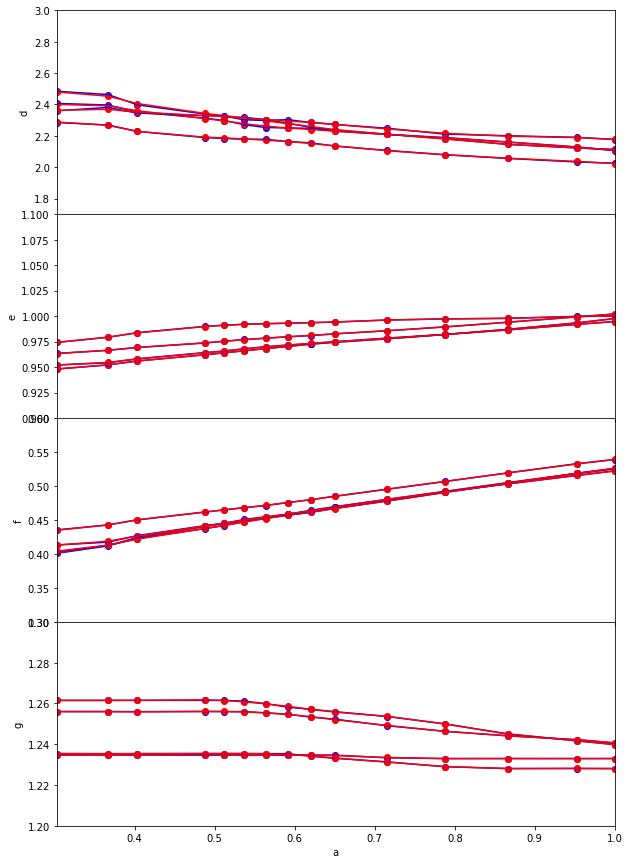

In [17]:

import matplotlib.pyplot as plt


fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(10,15), sharex=True)
wjat = ['Box_n50_0_1400', 'Box_n50_14_1400', 'Box_n50_33_1400', 'Box_n50_32_1400']
# wjat = [leave_out_box, 'Box98_1400']

# for box in [leave_out_box]:#, 'Box_n50_14_1400']:
# for box in [leave_out_box, 'Box98_1400', 'Box_n50_0_1400']:#, 'Box_n50_14_1400', 'Box_n50_33_1400', 'Box_n50_32_1400']:
for box in tqdm(wjat):
    curr_cosmo_vals = tuple(get_cosmo_vals(cosmo_params[box]))
    curr_ccl_cosmo = get_ccl_cosmology(curr_cosmo_vals)

    param_names = ['d','e','f','g']
    ndim = len(param_names)
    plt.subplots_adjust(wspace=0, hspace=0)

    params = {'d':[], 'e':[], 'f':[], 'g':[]}
    paramsEMU = {'d':[], 'e':[], 'f':[], 'g':[]}

    for a in a_list:
        R = 8 / (cosmo_params[box]['H0'] / 100)
        sigma8z = cosmo.sigmaR(R, a=a)
        EMU  = (Emulator.predict_params(cosmo_params[box], scaleToRedshift(a))) #, sigma8z))

        with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(box, a), "rb") as f:
            MLE_params = pickle.load(f)
        for key in MLE_params:
            params[key] += [MLE_params[key]]
            paramsEMU[key] += [EMU[key]]


    for i, param in enumerate(params):
        aaaaa = 1
        axs[i].scatter(a_list, params[param], alpha=aaaaa, color='blue')
#         print(list(zip(a_list,params[param])))
#         print()
        axs[i].plot(a_list, params[param], alpha=aaaaa, color='blue')

        axs[i].scatter(a_list, paramsEMU[param], alpha=aaaaa, color='red')
        axs[i].plot(a_list, paramsEMU[param], alpha=aaaaa, color='red')

        axs[i].set_ylabel(param)
    #     axs[i].set_ylim([0,2])
        axs[i].set_xlim([min(a_list), 1])

axs[-1].set_xlabel('a')
# axs[0].set_ylim([0.25,.45])
# axs[1].set_ylim([0.29,.305])
# axs[2].set_ylim([1.4,1.8])
# axs[3].set_ylim([1.18, 1.2])
axs[0].set_ylim([1.7, 3.])
axs[1].set_ylim([0.9, 1.1])
axs[2].set_ylim([.3,.6])
axs[3].set_ylim([1.2,1.3])
# axs[0].set_title(box)